# Plots

Lot of them.

In [1]:
from load_utils import load_data
from features import all_features
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rcParams
rcParams['figure.figsize'] = (12.0, 7.0)
plt.style.use('ggplot')

df, target = load_data()
features = all_features(df, test_set=True)

# Most flatten df: all columns are features
flat_df = pd.concat([features, target], axis=1)
flat_df = flat_df.stack('WF').reset_index(level='WF')

# With WF for the description; features in `var` column
melt_df = flat_df.reset_index().melt(id_vars=['Time', 'WF', 'Production'])  #value_name='value')

## Linear regression: Production vs. var, for each WF

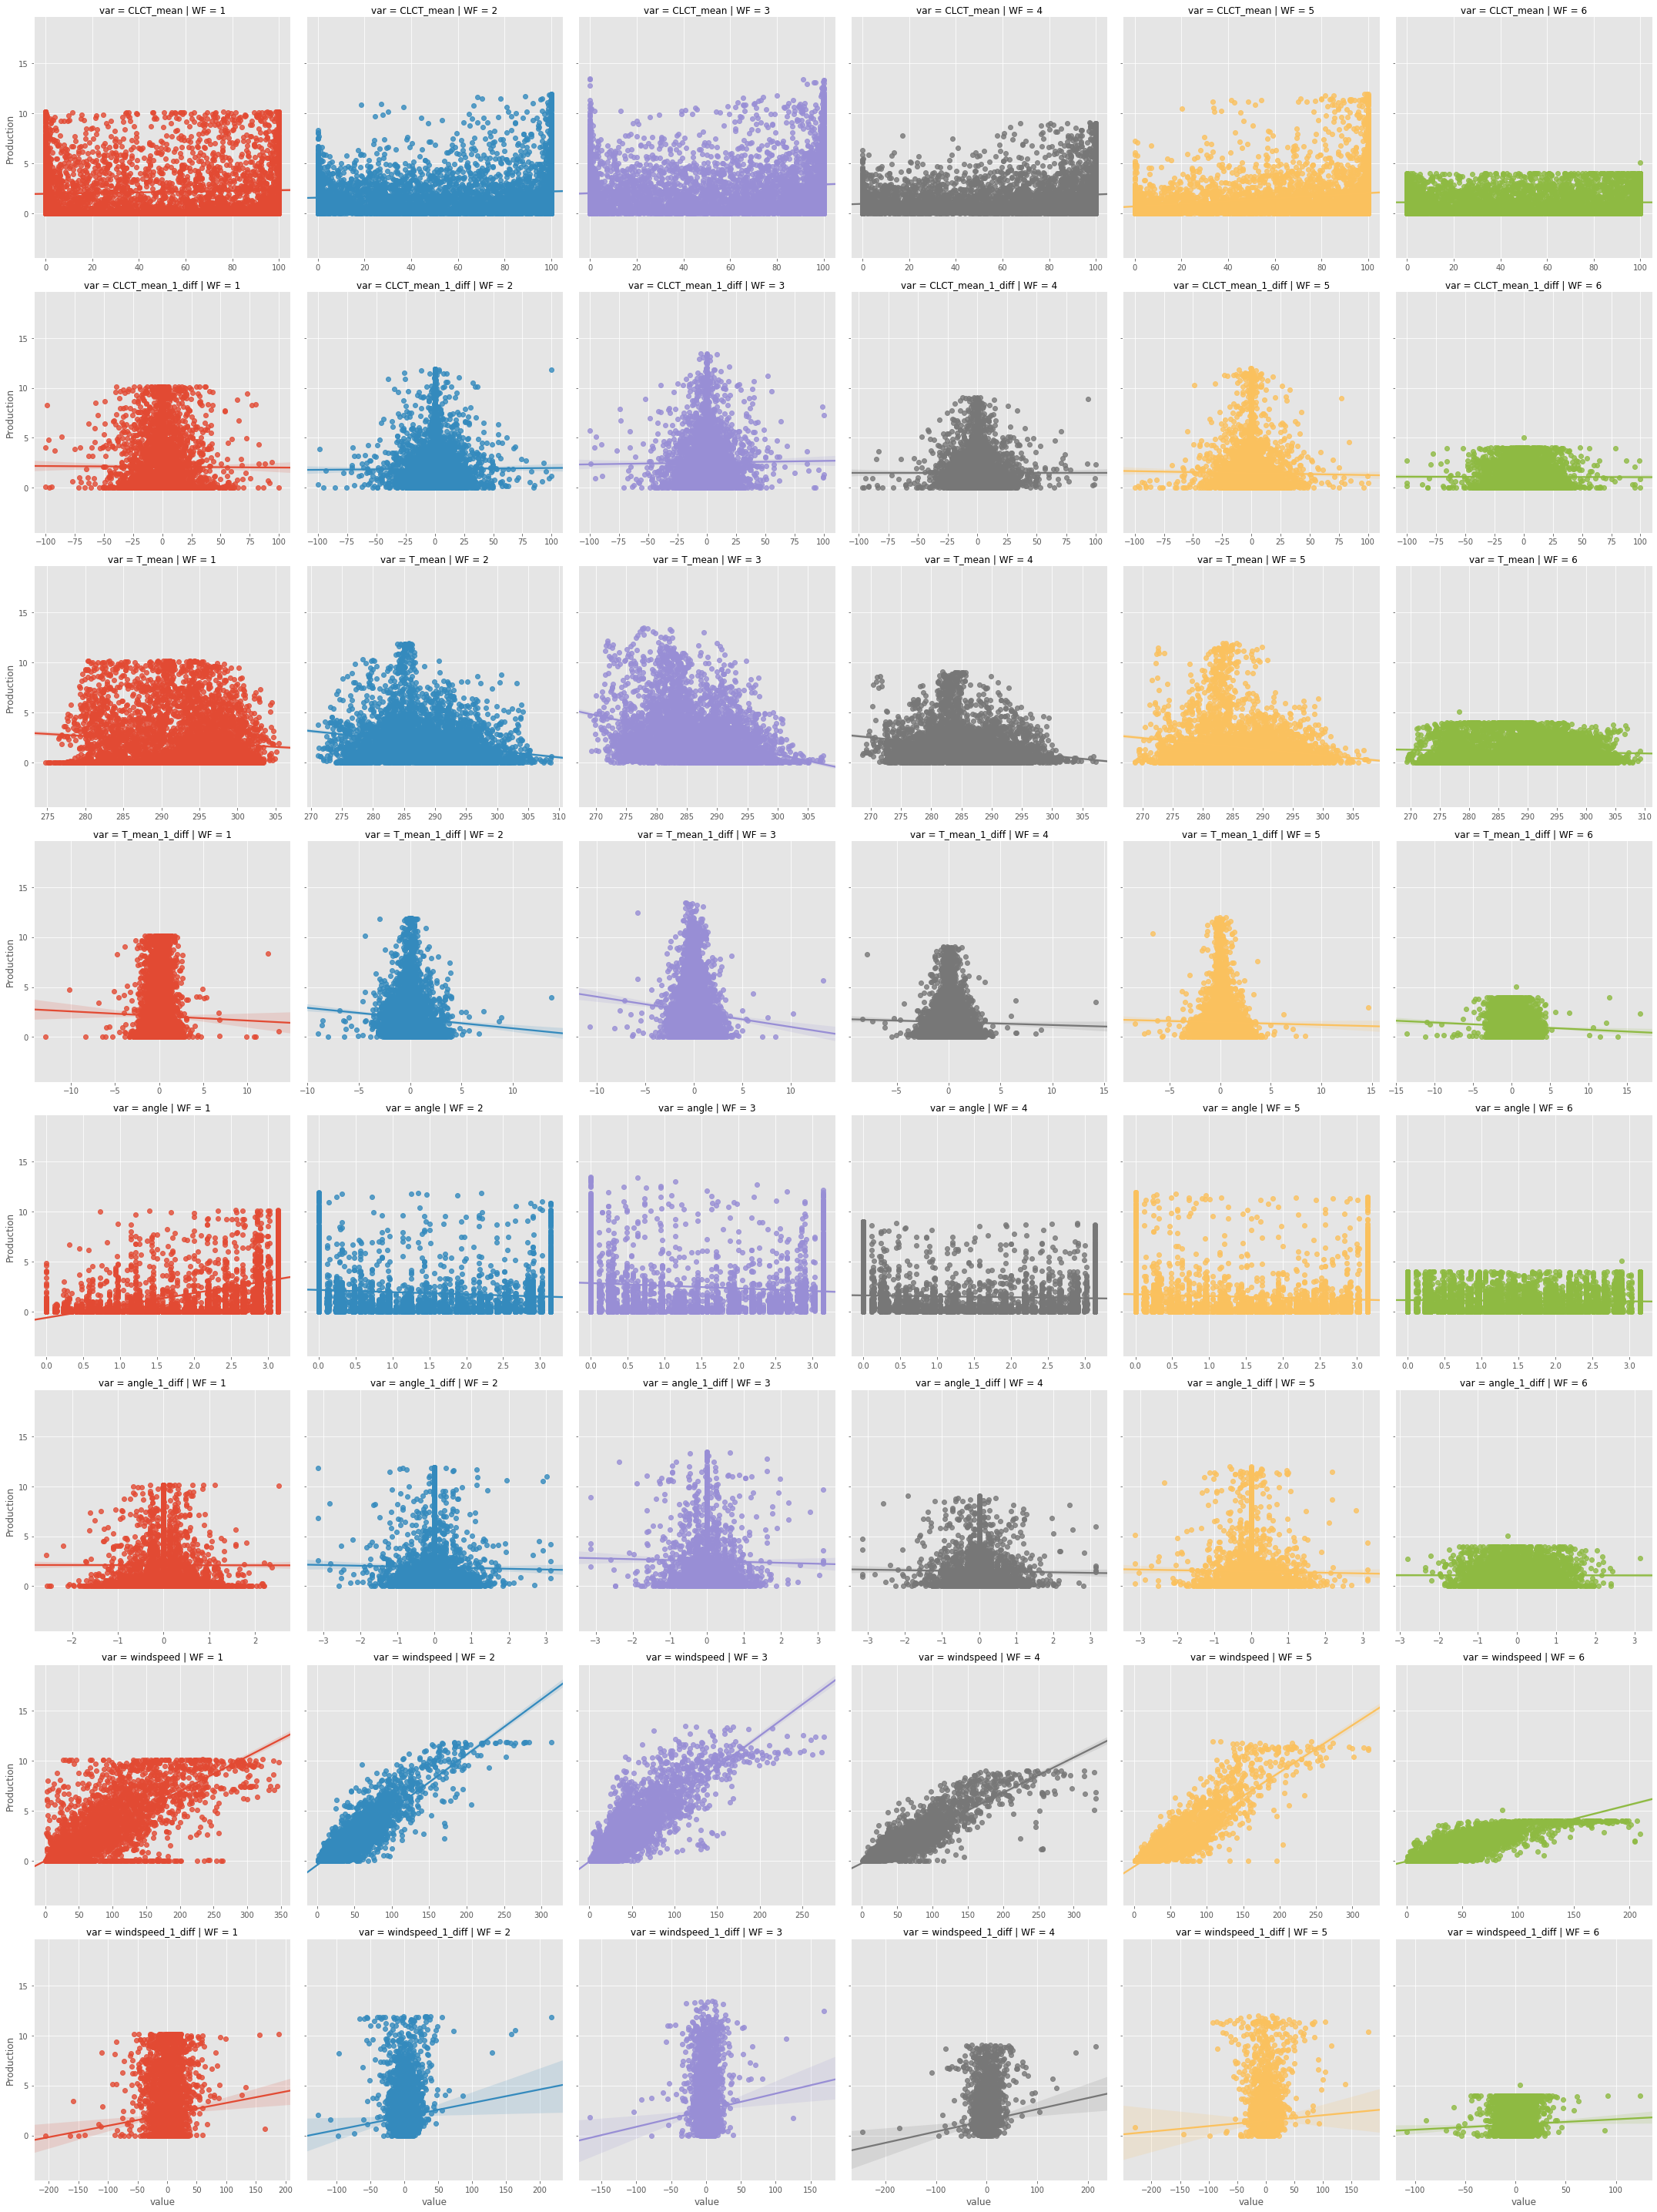

In [2]:
g = sns.lmplot(x='value', y='Production', col='WF', hue='WF', row='var', 
               data=melt_df, sharex=False, sharey=True)

In [3]:
g.savefig('samples/all_feat_regression.png')

## Production repartition for each WF

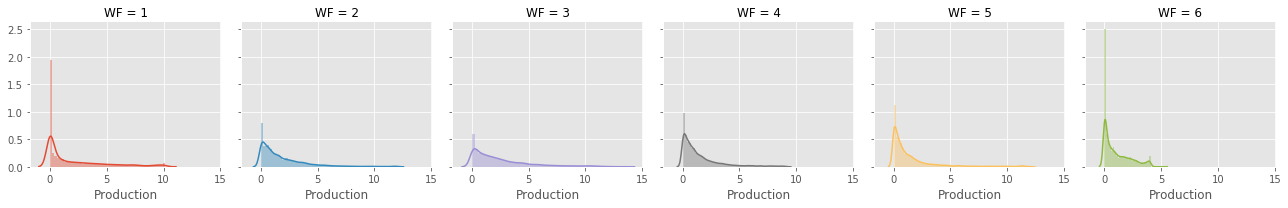

In [4]:
g = sns.FacetGrid(col='WF', hue='WF', data=melt_df)
g.map(sns.distplot, "Production")

In [5]:
g.savefig('samples/production_repartition_for_WF.png')

## Dimensionality reduction

Feature array: 

In [52]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import scale

In [53]:
X = flat_df.loc[:, [k for k in flat_df.columns if k not in ['WF', 'Production']]]
X = X.fillna(method='bfill')
X = X.fillna(method='ffill')
X = (X - X.mean(0)) / X.std(0)

# Dropping NaN values on the production
Y = flat_df['Production']
X = X[~Y.isna()]
Y = Y[~Y.isna()]

In [54]:
X.shape

(31183, 8)

### SVD

Singular Value Decomposition. The likes of Kernel PCA are not tractable with the number of samples. SVD works well in low dimension, with many samples.

In [9]:
model = TruncatedSVD()
X_reduced = model.fit_transform(X)

Text(0.5, 1.0, 'Projection on 2 first components of SVD. Color=Production.')

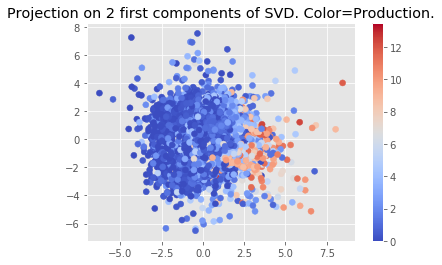

In [10]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='coolwarm')
plt.colorbar()
plt.title("Projection on 2 first components of SVD. Color=Production.")

Looks like Gaussian noise...

In [11]:
print(f"Explained variance ratio: {model.explained_variance_ratio_}\n"
      f"Baseline is (all equally important features): {1/X.shape[1]:.3f}")

Explained variance ratio: [0.17327036 0.15367077]
Baseline is (all equally important features): 0.125


Looks like a positive trends on the first component:

In [12]:
print("First component coefficients:\n")

for i in np.flip(np.argsort(np.abs(model.components_[0]))):
    name = X.columns[i]
    print(f"{name}: {model.components_[0][i]:.3f}")

First component coefficients:

CLCT_mean: 0.587
T_mean: -0.516
windspeed: 0.453
CLCT_mean_1_diff: 0.324
windspeed_1_diff: 0.190
T_mean_1_diff: -0.148
angle: 0.124
angle_1_diff: 0.077


### Lasso

In [13]:
from sklearn.linear_model import LassoCV

In [14]:
model = LassoCV(n_alphas=10, cv=10, normalize=True)
model.fit(X, Y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=10, n_jobs=None, normalize=True, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [15]:
print(f"Chosen alpha: {model.alpha_:.1e} (from {model.alphas_[-1]:.1e} to {model.alphas_[0]:.1e})")
print("Coefficients are:\n")
for i in np.flip(np.argsort(np.abs(model.coef_))):
    name = X.columns[i]
    print(f"{name}: {model.coef_[i]:.3f}")

Chosen alpha: 4.7e-05 (from 1.0e-05 to 1.0e-02)
Coefficients are:

windspeed: 1.786
windspeed_1_diff: -0.109
T_mean: -0.104
angle: -0.097
T_mean_1_diff: -0.016
angle_1_diff: 0.012
CLCT_mean: 0.007
CLCT_mean_1_diff: -0.000


## Approximated Kernel PCA

We can't use a naïve and standard approach, with KernelPCA & others. We have too many samples. We use first Nystrom sampling, which computes a low-rank approximation of the kernel matrix by sampling a subset of the training samples.

In [31]:
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from itertools import product

In [55]:
gammas = np.logspace(-2, 0, 5)
kernels = ['rbf', 'poly', 'sigmoid']
result = {}
for gamma, kernel in product(gammas, kernels):
    nystrom = Nystroem(gamma=gamma, kernel=kernel, n_components=500)
    model = Pipeline([("Feature transform", nystrom), ("PCA", PCA(n_components=2))])
    result[kernel, gamma] = model.fit_transform(X)

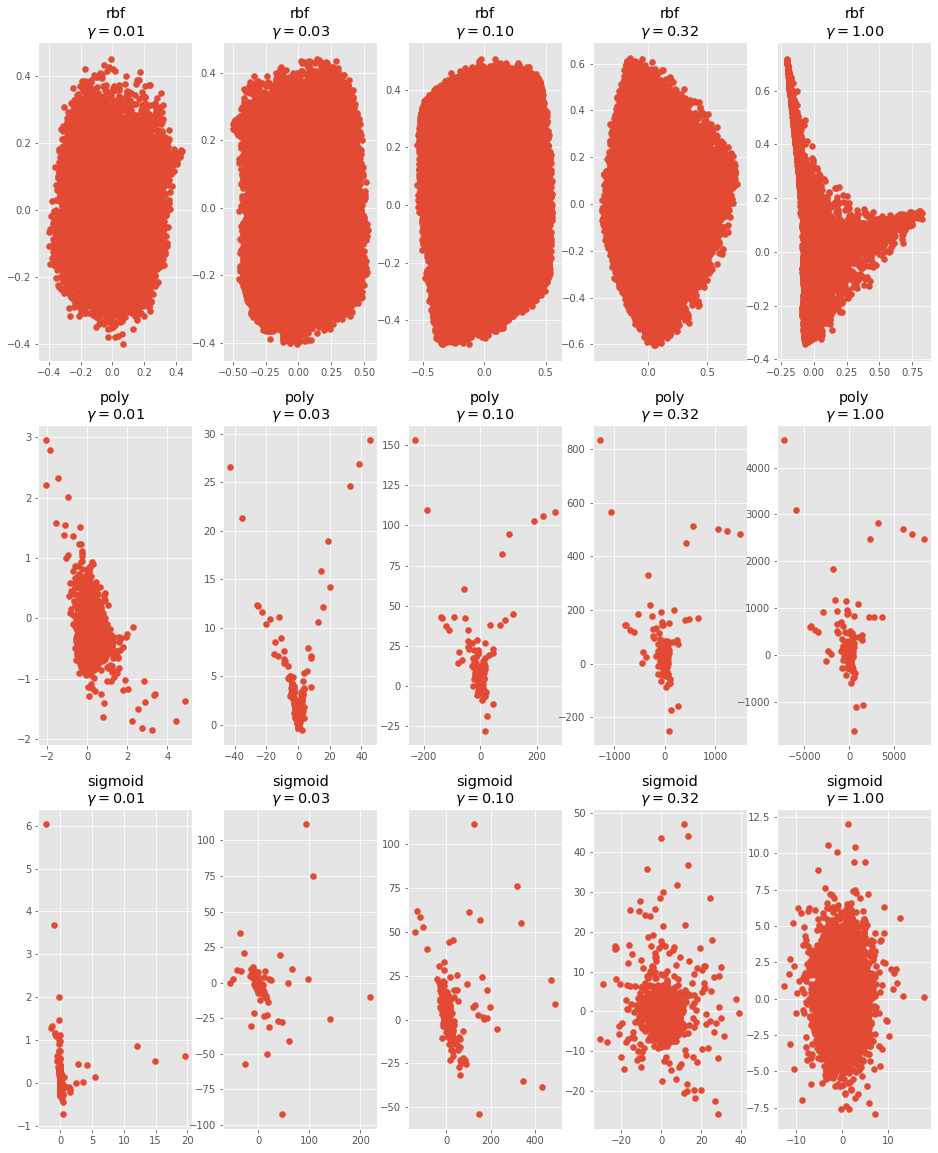

In [56]:
fig, axes = plt.subplots(3, 5, figsize=(16, 20))

for (label, X_reduced), ax in zip(result.items(), axes.T.flatten()):
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
    ax.set_title(f"{label[0]}\n$\gamma={label[1]:.2f}$")

## Approximated Kernel Ridge

This is Lasso in a feature map. Here, the feature map is an approximated Kernel Embedding (in a RKHS) with Nystrom. 

In [65]:
gammas = np.logspace(-2, 0, 3)
kernels = ['rbf', 'poly', 'sigmoid']
result = {}
for gamma, kernel in product(gammas, kernels):
    print(f"Doing kernel {kernel}, with gamma={gamma:.2f}")
    nystrom = Nystroem(gamma=gamma, kernel=kernel, n_components=500)
    X_reduced = nystrom.fit_transform(X)
#     model = Pipeline([("Feature transform", nystrom), ("Lasso", LassoCV(n_alphas=5, cv=5))])
    result[kernel, gamma] = LassoCV(n_alphas=5, cv=5, max_iter=int(1e4)).fit(X_reduced, Y)

Doing kernel rbf, with gamma=0.01
Doing kernel poly, with gamma=0.01
Doing kernel sigmoid, with gamma=0.01
Doing kernel rbf, with gamma=0.10
Doing kernel poly, with gamma=0.10
Doing kernel sigmoid, with gamma=0.10


/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2920.9189458963374, tolerance: 13.26174571181472
  tol, rng, random, positive)
/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 743.8039996331063, tolerance: 12.963631027680592
  tol, rng, random, positive)
/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 712.824496336405, tolerance: 12.135474861329271
  tol, rng, random, positive)
/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWar

Doing kernel rbf, with gamma=1.00
Doing kernel poly, with gamma=1.00


/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158.4305841395835, tolerance: 13.26174571181472
  tol, rng, random, positive)
/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265.8015755606684, tolerance: 12.135474861329271
  tol, rng, random, positive)
/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.45433515221521, tolerance: 12.214421489342207
  tol, rng, random, positive)
/home/gaspardb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

Doing kernel sigmoid, with gamma=1.00


In [84]:
print("Non zero coefficients | Dual Gap | MSE \n")
for (kernel, gamma), model in result.items():
    idx_alpha = np.argwhere(model.alphas_ == model.alpha_)[0, 0]
    mse_model = model.mse_path_[idx_alpha].mean()
    print(f"{kernel:10s} ({gamma:4.2f}) : {(model.coef_ != 0).sum():5d} | {model.dual_gap_:7.1f} | {mse_model:7.1f}")

Non zero coefficients | Dual Gap | MSE 

rbf        (0.01) :    95 |    15.3 |     1.6
poly       (0.01) :    69 |     5.8 |     1.6
sigmoid    (0.01) :    88 |    15.3 |     1.7
rbf        (0.10) :   338 |    15.3 |     1.7
poly       (0.10) :   120 |    15.3 |     1.7
sigmoid    (0.10) :   150 |    15.3 |     1.7
rbf        (1.00) :   430 |    14.2 |     3.2
poly       (1.00) :   149 |  1419.6 |     1.7
sigmoid    (1.00) :   384 |    15.0 |     1.7
